In [1]:
## Importing the required python libraries 
import os, sys
import warnings
import timeit
import numpy as np
import pandas as pd 
import pkg_resources
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import defaultdict


In [2]:
## Importing pergene files 

pergene_files=[]
#data_dir= "../satay/data_files/data_unmerged/"
#data_dir="../transposonmapper/data_files/files4test/"
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)

In [3]:
## Importing postproccesed data from pipeline
from ast import literal_eval
data_post=[]

for i in keys:
    data_post.append(pd.read_excel(data_dir+i+".xlsx",index_col="Unnamed: 0",engine='openpyxl'))
    
list_data_post=pd.concat(data_post,axis=0,keys=keys)
list_data_post.drop(columns=["Feature_alias","Feature_name"],inplace=True)
list_data_post.fillna(1,inplace=True)


## Linear normalization procedure

- Normalize the transposon density data per chromosome over the density of the chromosome. 
- Between datasets : normalize datasets such that their read-counts have the same mean(e.g. by dividing each transposon site by the total read-count).
- Refinement of this method: 

*A
refinement of this approach that is specific to TnSeq is to scale the read counts to have the
same mean over non-zero sites (which we call ‘Non-Zero Mean Normalization’ or
NZMean), since different datasets can have widely varying levels of saturation, and
distributing the same number of reads over fewer TA sites will naturally inflate the mean
read count among them.*

- Limitations: 

*One significant limitation of methods that linearly transform datasets is that they are susceptible to large spikes in read-counts. Because these methods multiply read-counts by a
constant scalar value, they cannot reduce large outliers without also affecting small read-
counts which are more common. Even if the datasets share the same mean, for instance, any
skew in distribution of read-counts itself would still be present.* From 1.DeJesus, M. A. & Ioerger, T. R. Normalization of transposon-mutant library sequencing datasets to improve identification of conditionally essential genes. J. Bioinform. Comput. Biol. 14, 1642004 (2016).

- The distribution of read-counts in most TnSeq datasets resembles a **Geometric-like
distribution, in that read-counts at most sites are small** (i.e. 1–50), with a (rapidly)
decreasing probability of sites with large counts. Ideally, a normalization method would
improve detection of conditionally essential genes between conditions by eliminating any
skew and making the datasets more closely fit this Geometric-like distribution.

In [4]:
backgrounds= ['wt_merged','bem1-aid_a','bem1-aid_b','dbem1dbem3_a','dbem1dbem3_b',
'dnrp1_merged','dbem3_merged']

In [5]:
chrom_length=pd.read_excel("../postprocessed-data/chromosome_length.xlsx",index_col="Chromosome")
chrom_length.drop(columns=["Unnamed: 0"],inplace=True)
chrom_length.loc["I"]

Length    230218
Name: I, dtype: int64

In [6]:
def linear_transformation_per_background(pergene_insertions_all_data,background,chrom_length,
windows_size=10000):
    """Executes the linear transformation procedure for a given background.
    It will divide the insertions and reads per gene over the total amount in each chromosome.

    Parameters
    ----------
    pergene_insertions_all_data : pandas.dataframe
        _description_
    background : list
        _description_
    chrom_length : pandas.dataframe
        _description_

    Returns
    -------
    _type_
        _description_
    """

    chrom=["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV",
    "XV","XVI"]

    data=pergene_insertions_all_data.copy()

    data_background=data.loc[background]
    

    reads_per_chrom=data_background.groupby(by=["Chromosome"]).sum()["Reads"]
    insertions_per_chrom=data_background.groupby(by=["Chromosome"]).sum()["Insertions"]

    data_background.index=data_background["Chromosome"]

    
    for i in chrom:

        data_background_chrom=data_background.loc[data_background["Chromosome"]==i]
        lengths_genes=data_background_chrom.loc[:,"End location"]-data_background_chrom.loc[:,"Start location"]

        data_background.loc[data_background["Chromosome"]==i,"Linear-norm-reads"]=data_background_chrom.loc[:,"Reads"]/reads_per_chrom[i]
        data_background.loc[data_background["Chromosome"]==i,"Linear-norm-insertions"]=data_background_chrom.loc[:,"Insertions"]/insertions_per_chrom[i]
        
        data_background.loc[data_background["Chromosome"]==i,"Linear-norm-tr-density"]=data_background.loc[data_background["Chromosome"]==i,"Linear-norm-insertions"]*np.divide(np.array(chrom_length.loc[i]),np.array(lengths_genes))

        data_background.loc[data_background["Chromosome"]==i,"tr-density"]=data_background_chrom.loc[:,"Insertions"]/lengths_genes
        data_background.loc[data_background["Chromosome"]==i,"length gene"]=lengths_genes
        
    data_without_index=data_background.copy()
    data_without_index.drop(columns=["Chromosome"],inplace=True)
    data_without_index.reset_index(inplace=True)

 #### Normalizing taking into account a windows size around the gene instead of the whole chromosome
    for gene in data_without_index["Gene name"].unique():
    
        location_gene=[data_without_index[data_without_index["Gene name"]==gene]["End location"].values[0],
                    data_without_index[data_without_index["Gene name"]==gene]["Start location"].values[0]]

       

        windows_location=[location_gene[0]-windows_size,location_gene[1]+windows_size]


        locations_ups=np.where((windows_location[0]<data_without_index["Start location"]) & (data_without_index["Start location"]<location_gene[0]))[0]
        locations_down=np.where((location_gene[1]<data_without_index["End location"]) & (data_without_index["End location"] < windows_location[1]))[0]

        locations_total=np.unique(np.concatenate((locations_ups,locations_down)))

        total_insertions=data_without_index.loc[locations_total,"Insertions"].sum()
        total_reads=data_without_index.loc[locations_total,"Reads"].sum()

        index_gene=np.where(data_without_index["Gene name"]==gene)[0][0]

        data_without_index.loc[index_gene,"tr_normalized_windows"]=data_without_index.loc[index_gene,"Insertions"]/total_insertions
        data_without_index.loc[index_gene,"reads_normalized_windows"]=data_without_index.loc[index_gene,"Reads"]/total_reads

    return data_without_index,reads_per_chrom,insertions_per_chrom
        

In [7]:
data_norm=[]
reads_per_chrom_list=[]
insertions_per_chrom_list=[]
for key in backgrounds:
    data_transformed,reads_per_chrom,insertions_per_chrom=linear_transformation_per_background(list_data_pd,key,
    chrom_length,windows_size=10000)
    data_norm.append(data_transformed)
    reads_per_chrom_list.append(reads_per_chrom)
    insertions_per_chrom_list.append(insertions_per_chrom)

data_norm_pd=pd.concat(data_norm,axis=0,keys=backgrounds)
reads_per_chrom_pd=pd.concat(reads_per_chrom_list,axis=0,keys=backgrounds)
insertions_per_chrom_pd=pd.concat(insertions_per_chrom_list,axis=0,keys=backgrounds)

/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
# data_norm_pd.to_excel("../postprocessed-data/data_norm_linear_transformation_all_backgrounds.xlsx")

In [9]:
reads_per_chrom_pd.loc["wt_merged"]["I"]

417717

(0.1, 100)

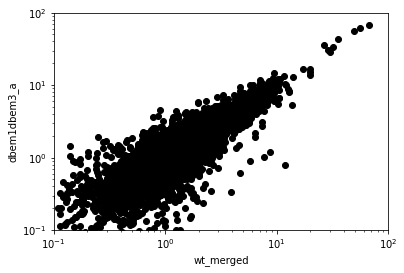

In [10]:
# comparison of libraries in terms of normalized transposon densityies 
mutant="dbem1dbem3_a"
plt.scatter(data_norm_pd.loc["wt_merged","Linear-norm-tr-density"],data_norm_pd.loc[mutant,"Linear-norm-tr-density"],color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wt_merged")
plt.ylabel(mutant)
plt.ylim(0.1,100)
plt.xlim(0.1,100)

In [11]:
## make a function that looks for the gene names that have more than 10 as transposon density
# in the mutant background and less than one in WT, and viceversa. 

In [12]:
data_norm_pd.loc["wt_merged"].columns

Index(['Chromosome', 'Gene name', 'Start location', 'End location',
       'Insertion locations', 'Reads per insertion location', 'Reads',
       'Insertions', 'Linear-norm-reads', 'Linear-norm-insertions',
       'Linear-norm-tr-density', 'tr-density', 'length gene',
       'tr_normalized_windows', 'reads_normalized_windows'],
      dtype='object')

In [21]:
def linear_transformations_plots(normalized_data,type,background,saveFigure=False):
    """_summary_

    Parameters
    ----------
    normalized_data : _type_
        _description_
    type : _type_
        _description_
    background : _type_
        _description_
    saveFigure : bool, optional
        _description_, by default False
    """        


    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,2))
    plt.subplots_adjust(wspace=0.8)

    data=normalized_data.loc[background]

    data=data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]      

    if type=="reads":
        
        
        cols=["Reads","Linear-norm-reads","reads_normalized_windows"]
        labels=["Raw reads","Norm. over chrom.","Norm. over 10kb windows"]

        fig.suptitle("Linear transformation of the reads",y=1.1,fontsize=18)
        
        for axes in ax:
            axes.set_ylim(0,3000)

        ax[0].set_xlim(0,np.max(data[cols[0]])/40)
        ax[1].set_xlim(0,np.max(data[cols[1]])/40)
        ax[2].set_xlim(0,np.max(data[cols[2]])/40)

        sns.histplot(data[cols[0]],ax=ax[0],color="gray",binwidth=np.max(data[cols[0]])/1000)

        ax[0].set_xlabel(labels[0],fontsize=12)
        
        sns.histplot(data[cols[1]],ax=ax[1],color="blue",binwidth=np.max(data[cols[1]])/1000)
        
        ax[1].set_xlabel(labels[1],fontsize=12)

        sns.histplot(data[cols[2]],ax=ax[2],color="red", binwidth=np.max(data[cols[2]])/1000)
            
        ax[2].set_xlabel(labels[2],fontsize=12)
   

    elif type=="insertions":
        

        cols=["Insertions","Linear-norm-insertions","tr_normalized_windows"]
        labels=["Raw insertions","Norm. over chrom.","Norm. over 10kb windows"]
        
        fig.suptitle("Linear transformation of the insertions",y=1.1,fontsize=18)

        for axes in ax:
             axes.set_ylim(0,1000)

        ax[0].set_xlim(0,np.max(data[cols[0]])/15)
        ax[1].set_xlim(0,np.max(data[cols[1]])/15)
        ax[2].set_xlim(0,np.max(data[cols[2]])/15)

        ax[0].set_ylabel("Frequency",fontsize=12)
        ax[1].set_ylabel(" ")   
        ax[2].set_ylabel(" ")
        


        sns.histplot(data[cols[0]],ax=ax[0],color="gray",binwidth=np.max(data[cols[0]])/1000)

        ax[0].set_xlabel(labels[0],fontsize=12)
        
        sns.histplot(data[cols[1]],ax=ax[1],color="blue",binwidth=np.max(data[cols[1]])/1000)
        
        ax[1].set_xlabel(labels[1],fontsize=12)

        sns.histplot(data[cols[2]],ax=ax[2],color="red", binwidth=np.max(data[cols[2]])/1000)
            
        ax[2].set_xlabel(labels[2],fontsize=12)

    elif type=="transposon density":

        cols=["tr-density","Linear-norm-tr-density","length gene"]
        labels=["Insertion density (1/bp)","Norm. over chrom.(1/bp)","Gene length (bp)"]

        
        fig.suptitle("Transposon density normalization",y=1.1,fontsize=18)

        ax[0].set_xlim(0,np.max(data[cols[0]])/15)
        ax[1].set_xlim(0,np.max(data[cols[1]])/15)
        ax[2].set_xlim(0,np.max(data[cols[2]]/4))

        for axes in ax:
            axes.set_ylim(0,400)

        ax[0].set_ylabel("Frequency",fontsize=12)
        ax[1].set_ylabel(" ")   
        ax[2].set_ylabel(" ")
        


        sns.histplot(data[cols[0]],ax=ax[0],color="gray",binwidth=np.max(data[cols[0]])/1000)

        ax[0].set_xlabel(labels[0],fontsize=12)
        
        sns.histplot(data[cols[1]],ax=ax[1],color="blue",binwidth=np.max(data[cols[1]])/1000)
        
        ax[1].set_xlabel(labels[1],fontsize=12)

        sns.histplot(data[cols[2]],ax=ax[2],color="red", binwidth=np.max(data[cols[2]])/1000)
            
        ax[2].set_xlabel(labels[2],fontsize=12)

    elif type=="plot-genome-insertions": 
        
        coordinates_chrom=[]
        chrom=["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI"]

        y=[]
        y_linear=[]
        y_windows=[]

        cols=["Insertions","Linear-norm-insertions","tr_normalized_windows"]
        labels=["Raw insertions","Norm. over chrom.","Norm. over 10kb"]
        
        for i in chrom:
        
            coordinates_chrom.append((np.where(data["Chromosome"]==i)[0][0]))
            
            

            y.append(data[data["Chromosome"]==i][cols[0]])
            y_linear.append(data[data["Chromosome"]==i][cols[1]])
            y_windows.append(data[data["Chromosome"]==i][cols[2]])
        

        fig.suptitle("Genome wise data normalization",y=1.1,fontsize=18)

        sns.lineplot(data=np.concatenate(y),ax=ax[0],color="black")
        sns.lineplot(data=np.concatenate(y_linear),ax=ax[1],color="blue")
        sns.lineplot(data=np.concatenate(y_windows),ax=ax[2],color="red")

        ax[0].set_ylabel(labels[0],fontsize=12)
        ax[1].set_ylabel(labels[1],fontsize=12)
        ax[2].set_ylabel(labels[2],fontsize=12)

        for axes in ax:
            axes.set_xlabel("Gene positions",fontsize=12)
            

    elif type=="plot-genome-reads": 
    
        coordinates_chrom=[]
        chrom=["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI"]

        y=[]
        y_linear=[]
        y_windows=[]

        cols=["Reads","Linear-norm-reads","reads_normalized_windows"]
        labels=["Raw reads","Norm. over chrom.","Norm. over 10kb"]

        for i in chrom:
        
            coordinates_chrom.append((np.where(data["Chromosome"]==i)[0][0]))

            y.append(data[data["Chromosome"]==i][cols[0]])
            y_linear.append(data[data["Chromosome"]==i][cols[1]])
            y_windows.append(data[data["Chromosome"]==i][cols[2]])

        fig.suptitle("Genome wise data normalization",y=1.1,fontsize=18)

        sns.lineplot(data=np.concatenate(y),ax=ax[0],color="black")
        sns.lineplot(data=np.concatenate(y_linear),ax=ax[1],color="blue")
        sns.lineplot(data=np.concatenate(y_windows),ax=ax[2],color="red")

        ax[0].set_ylabel(labels[0],fontsize=12)
        ax[1].set_ylabel(labels[1],fontsize=12)
        ax[2].set_ylabel(labels[2],fontsize=12)

        for axes in ax:
            axes.set_xlabel("Gene positions",fontsize=12)


    elif type=="plot-genome-density": 
    
        coordinates_chrom=[]
        chrom=["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI"]

        y=[]
        y_linear=[]
        y_windows=[]

        cols=["tr-density","Linear-norm-tr-density","length gene"]
        labels=["Insertion density (1/bp)","Over chrom.(1/bp)","Gene length (bp)"]

        for i in chrom:
        
            coordinates_chrom.append((np.where(data["Chromosome"]==i)[0][0]))

            y.append(data[data["Chromosome"]==i][cols[0]])
            y_linear.append(data[data["Chromosome"]==i][cols[1]])
            y_windows.append(data[data["Chromosome"]==i][cols[2]])

        fig.suptitle("Genome wise data normalization",y=1.2,fontsize=18)

        sns.lineplot(data=np.concatenate(y),ax=ax[0],color="black")
        sns.lineplot(data=np.concatenate(y_linear),ax=ax[1],color="blue")
        sns.lineplot(data=np.concatenate(y_windows),ax=ax[2],color="red")

        ax[0].set_title(labels[0],fontsize=12)
        ax[1].set_title(labels[1],fontsize=12)
        ax[2].set_title(labels[2],fontsize=12)

        for axes in ax:
            axes.set_xlabel("Gene positions",fontsize=12)
            

            
    for axes in ax:
        axes.tick_params(axis='x', labelsize=16)
        axes.tick_params(axis='y', labelsize=16)

    

    

    if saveFigure:
        fig.savefig("../figures/linear_transformation_"+background+"_"+type+".png",
        bbox_inches="tight",dpi=400)

    

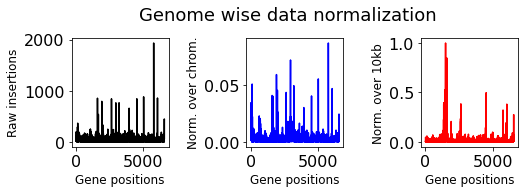

In [22]:
linear_transformations_plots(data_norm_pd,type="plot-genome-insertions",background="wt_merged")

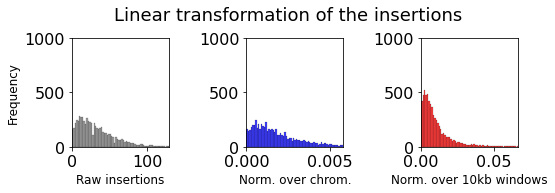

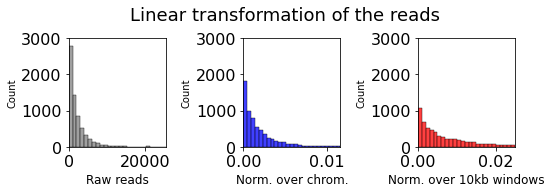

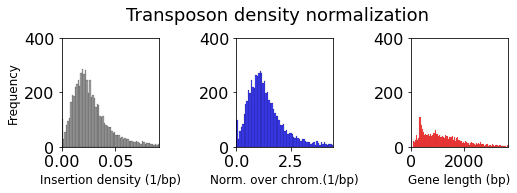

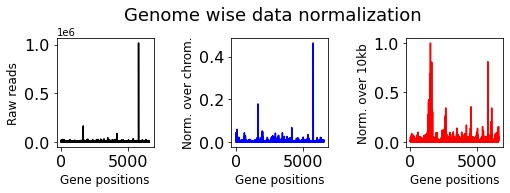

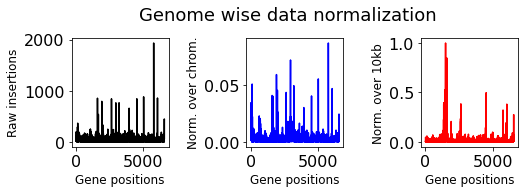

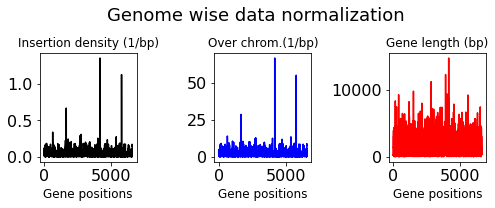

In [109]:
types=["insertions","reads","transposon density","plot-genome-reads",
"plot-genome-insertions","plot-genome-density"]
for i in types:
    linear_transformations_plots(data_norm_pd,i,"wt_merged",saveFigure=True)

In [24]:
def linear_transformations_plots_per_chrom(normalized_data,background,type,chrom="I",
saveFigure=False):
    """_summary_

    Parameters
    ----------
    normalized_data : _type_
        _description_
    background : _type_
        _description_
    type : _type_
        _description_
    chrom : str, optional
        _description_, by default "I"
    saveFigure : bool, optional
        _description_, by default False
    """


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,2))
    
    data=normalized_data.loc[background]
    data=data[data["Chromosome"]==chrom]
    data=data[~data.isin([np.nan, np.inf, -np.inf]).any(1)] 
    
    
    if type=="plot-genome-density": 
    
        cols=["tr-density","Linear-norm-tr-density"]
        labels=["Insertion density (1/bp)","Over chrom.(1/bp)"]

        

        fig.suptitle("Normalization over chrom:"+chrom,y=1.2,fontsize=18)

        sns.lineplot(data=data.loc[:,cols[0]],ax=ax[0],color="black")
        sns.lineplot(data=data.loc[:,cols[1]],ax=ax[1],color="red")

        ax[0].set_title(labels[0],fontsize=12)
        ax[1].set_title(labels[1],fontsize=12)

    elif type=="plot-genome-insertions":
            
            cols=["Insertions","tr_normalized_windows"]
            labels=["Raw insertions","Over 10kb on chrom."]
    
            fig.suptitle("Normalization over 10kb on chrom:"+chrom,y=1.2,fontsize=18)
    
            sns.lineplot(data=data.loc[:,cols[0]],ax=ax[0],color="black")
            sns.lineplot(data=data.loc[:,cols[1]],ax=ax[1],color="red")
    
            ax[0].set_title(labels[0],fontsize=12)
            ax[1].set_title(labels[1],fontsize=12)

    elif type=="plot-genome-reads":
        
        cols=["Reads","reads_normalized_windows"]
        labels=["Raw reads","Over 10kb on chrom."]

        fig.suptitle("Normalization over 10kb on chrom:"+chrom,y=1.2,fontsize=18)

        sns.lineplot(data=data.loc[:,cols[0]],ax=ax[0],color="black")
        sns.lineplot(data=data.loc[:,cols[1]],ax=ax[1],color="red")

        ax[0].set_title(labels[0],fontsize=12)
        ax[1].set_title(labels[1],fontsize=12)
        

    for axes in ax:
        axes.tick_params(axis='x', labelsize=16)
        axes.tick_params(axis='y', labelsize=16)
        axes.set_xlabel("Gene positions",fontsize=12)
        axes.set_ylabel(" ",fontsize=12)
    
    
            

    if saveFigure:
        fig.savefig("../figures/linear_transformation_"+background+"_"+type+"_"+chrom+".png",
        bbox_inches="tight",dpi=400)
            
    
        

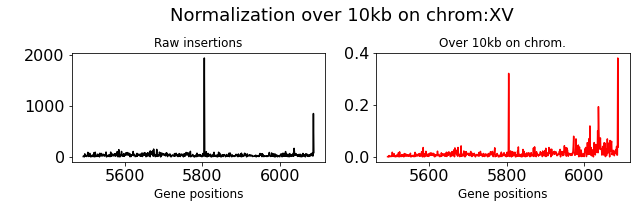

In [25]:
linear_transformations_plots_per_chrom(data_norm_pd,"wt_merged","plot-genome-insertions",chrom="XV",saveFigure=True)

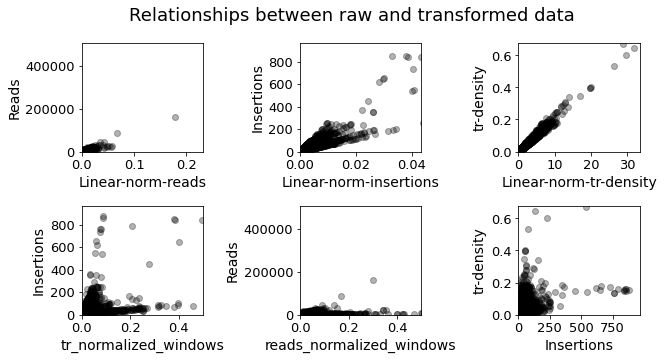

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

plt.subplots_adjust(wspace=0.8)
plt.subplots_adjust(hspace=0.5)

data=data_norm_pd.loc["wt_merged"]
data=data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]    

values=["Linear-norm-reads","Reads","Linear-norm-insertions","Insertions",
"Linear-norm-tr-density","tr-density","tr_normalized_windows","Insertions",
"reads_normalized_windows","Reads","Insertions","tr-density"]

fig.suptitle("Relationships between raw and transformed data",fontsize=18)

j=0
for i in np.arange(0,6):
    plt.subplot(2,3,i+1)
    x=data.loc[:,values[j]]
    y=data.loc[:,values[j+1]]
    plt.scatter(x,y,color="black",alpha=0.3)
    
    plt.xlabel(values[j],fontsize=14)
    plt.ylabel(values[j+1],fontsize=14)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.ylim(0,np.max(y)/2)
    plt.xlim(0,np.max(x)/2)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    j=j+2


fig.savefig("../figures/figures_thesis_chapter_2/linear_relationships-data.png",bbox_inches="tight",dpi=400)
#ax[1,2].set_axis_off()


## There is a problem with the pergene insertion file!!!!!

### Problem:
 **The data does not go continously from chromosome 1 to 16.** After chromosome 4 it jumps to chromosome 9,  then goes to Mitochondrial chromosome and then continues to chromosome 5 until 16. 

### Consequence:

**We can not plot the pergene insertion file as it is because the data is not continously from chromosome 1 to 16.**

## Possible solutions:

- Plot the data, from the pergene insertions file by matching the data to every chromosome number , not as it is. 



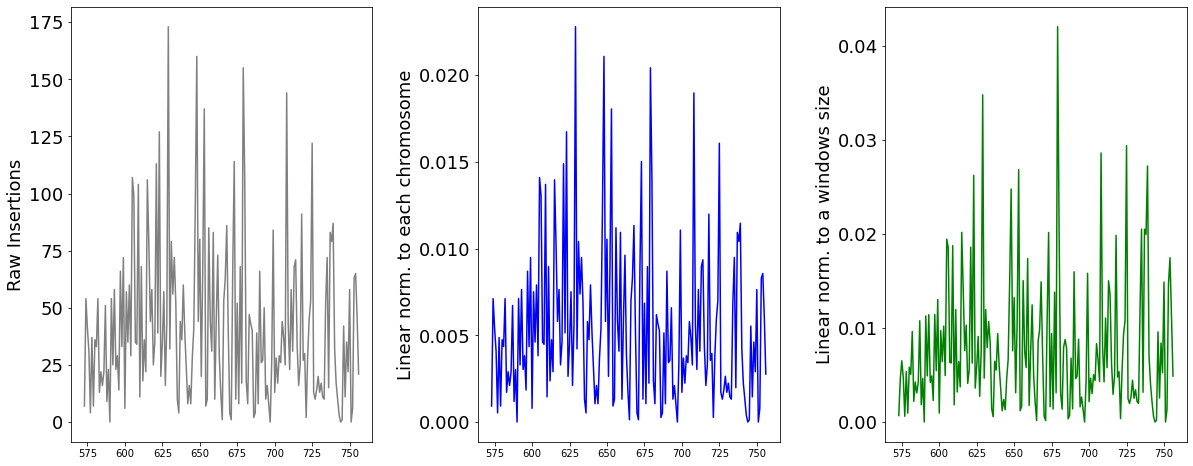

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
data=data_norm_pd.loc["wt_merged"]
coordinates_chrom=[]
chrom=["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI"]
i=2
y_insertions=data[data["Chromosome"]==chrom[i]]["Insertions"]
y_linear=data[data["Chromosome"]==chrom[i]]["Linear-norm-insertions"]
y_windows=data[data["Chromosome"]==chrom[i]]["tr_normalized_windows"]




plt.subplots_adjust(wspace=0.35)
plt.subplot(1,3,1)
plt.plot(y_insertions,color="gray")
#plt.plot(data.index,data.loc[:,"Insertions"],color="gray")
#plt.xticks(coordinates_chrom,chrom,fontsize=10,rotation=90);
plt.ylabel("Raw Insertions",fontsize=18)
# plt.ylim(0,250000)
plt.yticks(fontsize=18)

plt.subplot(1,3,2)
#plt.plot(data.index,data.loc[:,"Linear-norm-insertions"],color="blue")
plt.plot(y_linear,color="blue")
# # plt.ylim(0,0.25)
plt.ylabel("Linear norm. to each chromosome",fontsize=18)
#plt.xticks(coordinates_chrom,chrom,fontsize=18,rotation=90);
plt.yticks(fontsize=18);

plt.subplot(1,3,3)
#plt.plot(data.index,data.loc[:,"tr_normalized_windows"],color="gray")
plt.plot(y_windows,color="green")
# # plt.ylim(0,0.25)
plt.ylabel("Linear norm. to a windows size",fontsize=18)
# #plt.xticks(coordinates_chrom,chrom,fontsize=18,rotation=90);
plt.yticks(fontsize=18);


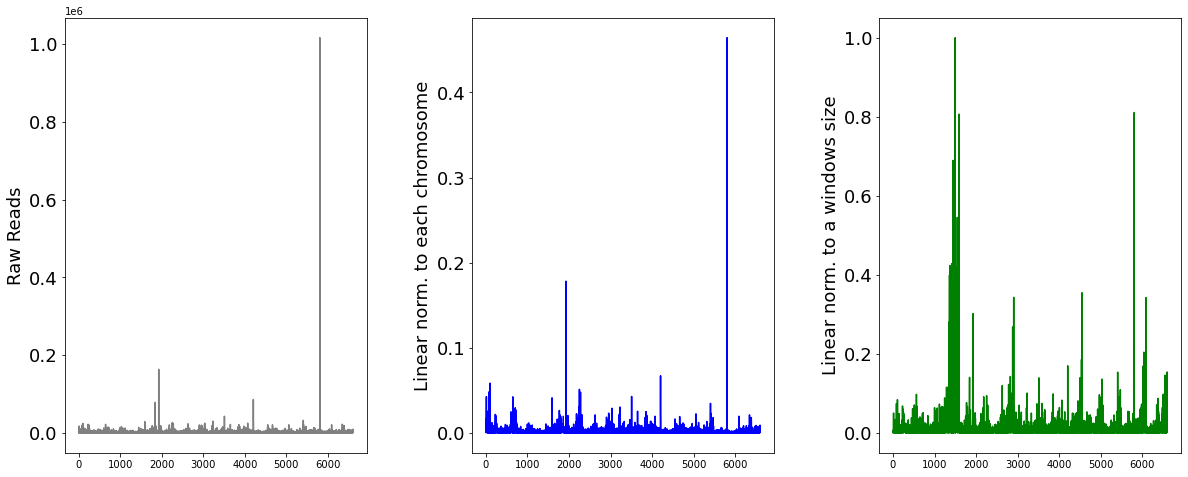

In [159]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))

coordinates_chrom=[]
chrom=["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI"]

for i in chrom:
   
    coordinates_chrom.append((np.where(data["Chromosome"]==i)[0][0]))


plt.subplots_adjust(wspace=0.35)
plt.subplot(1,3,1)
plt.plot(data.index,data.loc[:,"Reads"],color="gray")
#plt.xticks(coordinates_chrom,chrom,fontsize=10,rotation=90);
plt.ylabel("Raw Reads",fontsize=18)
# plt.ylim(0,250000)
plt.yticks(fontsize=18)

plt.subplot(1,3,2)
plt.plot(data.index,data.loc[:,"Linear-norm-reads"],color="blue")
# plt.ylim(0,0.25)
plt.ylabel("Linear norm. to each chromosome",fontsize=18)
#plt.xticks(coordinates_chrom,chrom,fontsize=18,rotation=90);
plt.yticks(fontsize=18);

plt.subplot(1,3,3)
plt.plot(data.index,data.loc[:,"reads_normalized_windows"],color="green")
# plt.ylim(0,0.25)
plt.ylabel("Linear norm. to a windows size",fontsize=18)
#plt.xticks(coordinates_chrom,chrom,fontsize=18,rotation=90);
plt.yticks(fontsize=18);


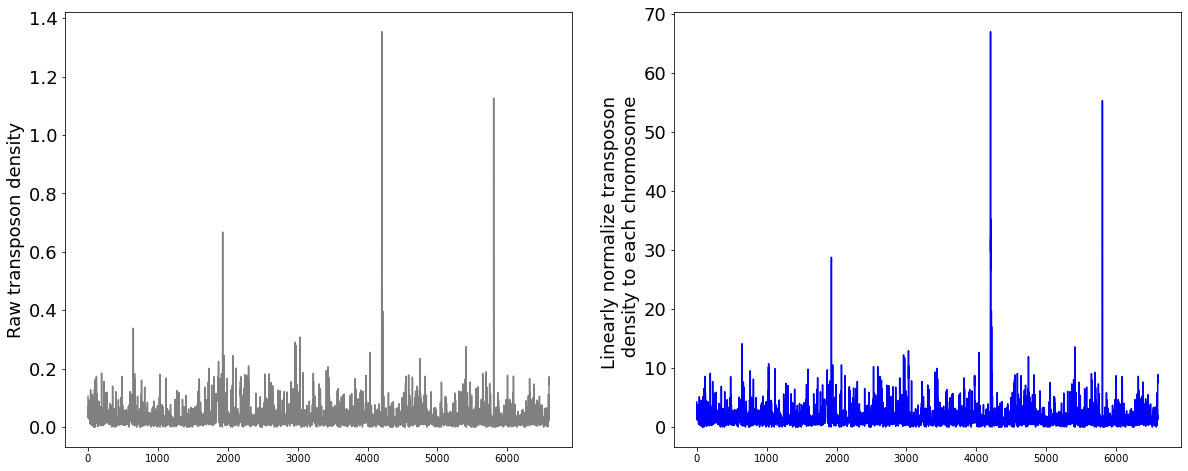

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

coordinates_chrom=[]

for i in chrom:
    coordinates_chrom.append((np.where(data["Chromosome"]==i)[0][0]))

plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plt.plot(data.index,data.loc[:,"tr-density"],color="gray")
#plt.xticks(coordinates_chrom,chrom,fontsize=18,rotation=90);
plt.ylabel("Raw transposon density",fontsize=18)
# plt.ylim(0,250000)
plt.yticks(fontsize=18)

plt.subplot(1,2,2)
plt.plot(data.index,data.loc[:,"Linear-norm-tr-density"],color="blue")
# plt.ylim(0,0.25)
plt.ylabel("Linearly normalize transposon \n density to each chromosome",fontsize=18)
#plt.xticks(coordinates_chrom,chrom,fontsize=18,rotation=90);
plt.yticks(fontsize=18);

In [78]:
## Normalize the insertions counts according a moving windows of size 100kb

data=data_norm_wt.copy()
data.drop(columns=["Chromosome"],inplace=True)
data.reset_index(inplace=True)

gene="CDC42"
location_gene=[data[data["Gene name"]==gene]["End location"].values[0],
                     data[data["Gene name"]==gene]["Start location"].values[0]]

windows=10000

windows_location=[location_gene[0]-windows,location_gene[1]+windows]


locations_ups=np.where((windows_location[0]<data["Start location"]) & (data["Start location"]<location_gene[0]))[0]
locations_down=np.where((location_gene[1]<data["End location"]) & (data["End location"] < windows_location[1]))[0]

locations_total=np.unique(np.concatenate((locations_ups,locations_down)))

total_insertions=data.loc[locations_total,"Insertions"].sum()

                     

In [81]:
total_insertions,insertions_per_chrom_pd.loc["wt_merged"]["XII"], data["Insertions"].sum()

(3251, 21782, 246538)

## Make a quantile quantile plot of the reads counts over the genes to have an idea of how deviated from a normal distribution is this. 

- Sources: https://towardsdatascience.com/understand-q-q-plot-using-simple-python-4f83d5b89f8f
- https://seaborn-qqplot.readthedocs.io/en/latest/

## Non linear normalization procedure

- Normalize the reads data per chromosome to fit a beta geometric distribution with parameters alpha and beta.
- The beta geometric distribution (also called the Type I Geometric) is a type of geometric distribution, where the probability of success parameter, p, has a Beta distribution with shape parameters alpha(α) and beta(β); both shape parameters are positive (α > 0 and β > 0).
- It is a type of compound distribution.

- See an example here: https://stackoverflow.com/questions/59308441/fitting-for-discrete-data-negative-binomial-poisson-geometric-distribution

- https://www.geeksforgeeks.org/python-discrete-geometric-distribution-in-statistics/